# Problem Statement

1. Who is not eligible for benefit? (outlier)
2. How much we should pay for eligible families?

In [1]:
from models import AnomalyDetection
from helper_functions import Tools
import pandas as pd
import numpy as np
import glob
from datetime import date
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Load The Dataset

In [2]:
def read_files():
    folder = sorted(glob.glob("./data/*.csv"))
    dfs = [pd.read_csv(f, sep=",", header=0) for f in folder]

    drop = {'drop_application': ['START_TIME','STREET_NAME', 'BIRTH_DATE', 'FIRST_NAME', 'LAST_NAME', 'EMAIL', 'HOME_AREA_CODE', 'PHONE_NUMBER',
                                 'EMPLOYMENT_STATUS'],
            'drop_dependent': ['P8N', 'PARTNER_P8N', 'DATE_BIRTH_7', 'DATE_BIRTH_8', 'DATE_BIRTH_9'],
            'drop_server': ['USERAGENT', 'SCREEN_SIZE',	'WINDOW_SIZE', 'bot_score']}
    dfs[0] = dfs[0].drop(drop['drop_application'], axis=1)
    dfs[2] = dfs[2].drop(drop['drop_dependent'], axis=1)
    dfs[4] = dfs[4].drop(drop['drop_server'], axis=1)

    # don't need to merge server-log-data and spouse-common-law-data
    df = dfs[0].merge(dfs[1], on='APP_ID').merge(dfs[2], on='APP_ID').merge(dfs[3], on='APP_ID').merge(dfs[4], on='APP_ID')

    return df

In [15]:
file = read_files()

In [16]:
print(file.shape)
file

(186958, 20)


,APP_ID,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,TRANSIT_NUMBER,DATE_BIRTH_1,DATE_BIRTH_2,DATE_BIRTH_3,DATE_BIRTH_4,DATE_BIRTH_5,DATE_BIRTH_6,employment_income_1,employment_income_2,uip_address
0,100000,2023-01-01:00:51:58,39916021.0,65771788.0,COURTICE,L1E0J2,6.0,800,925,6.709730e+11,14620.0,2016-12-06,NaN,NaN,NaN,NaN,NaN,1176.136251,416.158132,Kiara.Phillip.Jagger.Brandon
1,100001,2023-01-01:01:19:03,28596991.0,25829667.0,SURREY,V3W9W5,10.0,1500,284,7.343450e+11,93305.0,2019-10-17,2022-06-10,NaN,NaN,NaN,NaN,21058.120853,13290.879147,Alexzandria.Vanisha.Devyn.Shakari
2,100002,2023-01-01:01:32:07,65751811.0,63839036.0,VANCOUVER,V5Z1Y2,10.0,1500,248,1.454530e+11,64103.0,2019-08-05,2013-06-19,NaN,NaN,NaN,NaN,7423.732510,986.966806,Mun.Connor.Widdad.Minnah
3,100003,2023-01-01:02:24:04,43012353.0,73277757.0,MARKHAM,L3R8A5,6.0,800,499,7.194850e+11,65314.0,2013-11-29,NaN,NaN,NaN,NaN,NaN,31129.608140,0.000000,Julienne.Christine.Humza.Lubna
4,100004,2023-01-01:02:42:20,34120896.0,72359770.0,RICHMOND,V7A3Y7,10.0,800,248,2.990500e+11,20629.0,2021-05-11,NaN,NaN,NaN,NaN,NaN,12181.918095,1363.765599,Abyad.Alexandra.Saadiq.Selena
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186953,286953,2023-03-31:03:29:47,39587551.0,78857785.0,MONTREAL,H1V1A6,5.0,0,121,9.644520e+11,27516.0,2016-10-21,NaN,NaN,NaN,NaN,NaN,6327.232148,14833.136305,Yazmeen.Malcolm.Tristen.Naseema
186954,286954,2023-03-31:03:26:19,46553423.0,68775805.0,FARNHAM,J2N2N1,5.0,0,456,1.353160e+11,91902.0,2018-09-22,2016-10-14,2013-07-25,NaN,NaN,NaN,13080.087279,2525.774133,Cherokee.Mitchell.Laramie.Joseph
186955,286955,2023-03-31:04:46:22,29927474.0,NaN,QUEBEC,G2B2E4,5.0,0,683,4.946310e+11,57894.0,2017-09-26,NaN,NaN,NaN,NaN,NaN,50968.204560,0.000000,Trae.Raafi.Rifa.Joshua
186956,286956,2023-03-31:04:51:05,64268904.0,28350988.0,SCARBOROUGH,M1J3P5,6.0,0,248,5.059810e+11,31755.0,2016-01-04,NaN,NaN,NaN,NaN,NaN,478.636732,213.383420,Gabriela.Diamond.Rasheeqa.Joshua


# Data Cleaning

### *Missing Values*

In [5]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186958 entries, 0 to 186957
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   APP_ID                        186958 non-null  int64  
 1   END_TIME                      186958 non-null  object 
 2   P8N                           186921 non-null  float64
 3   PARTNER_P8N                   158996 non-null  float64
 4   MUNICIPALITY_NAME             186958 non-null  object 
 5   POSTAL_CODE                   186844 non-null  object 
 6   PROVINCE__ID                  186844 non-null  float64
 7   CUMUL_PAY                     186958 non-null  int64  
 8   FINANCIAL_INSTITUTION_NUMBER  186958 non-null  int64  
 9   ACCOUNT_NUMBER                186958 non-null  float64
 10  TRANSIT_NUMBER                186958 non-null  float64
 11  DATE_BIRTH_1                  186958 non-null  object 
 12  DATE_BIRTH_2                  38830 non-null

In [6]:
# check for null
file.isnull().sum()

APP_ID                               0
END_TIME                             0
P8N                                 37
PARTNER_P8N                      27962
MUNICIPALITY_NAME                    0
POSTAL_CODE                        114
PROVINCE__ID                       114
CUMUL_PAY                            0
FINANCIAL_INSTITUTION_NUMBER         0
ACCOUNT_NUMBER                       0
TRANSIT_NUMBER                       0
DATE_BIRTH_1                         0
DATE_BIRTH_2                    148128
DATE_BIRTH_3                    178752
DATE_BIRTH_4                    184491
DATE_BIRTH_5                    186435
DATE_BIRTH_6                    186955
employment_income_1                  0
employment_income_2                  0
uip_address                          0
dtype: int64

In [17]:
# draft: make all null = 0
for i in file.columns:
    if file[i].isnull().sum() > 0:
        file[i] = file[i].fillna(0)

### *Update Values*

In [18]:
# update date of birth
for i in range(1,7):
    name = "DATE_BIRTH_" + str(i)
    if file[name].dtypes == object:
        # get the age
        file[name] = 2023 - file[name].str.split('-').str[0].fillna(0).astype("int")
        # all null and kids over 18 will be not eligible
        file[name].loc[(file[name] < 0) | (file[name] > 18)] = 99

In [19]:
# update time data types
file["END_TIME"] = pd.to_datetime(file["END_TIME"].str.split(':').str[0])

# Data Preprocessing

In [20]:
tag = ["CHECK_PAY", "VALID_INCOME", "VALID_P8N", "VALID_ADDRESS", "VALID_BANK_ACC", "VALID_KIDS", "VALID_AMOUNT", "SUSPICIOUS_BANK", "SUSPICIOUS_IP"]
for i in tag:
    file[i] = 0

## Mistake

### *Mistake - Policy*

In [28]:
for i in range(len(file)):
    total = file.employment_income_1[i] + file.employment_income_2[i]
    if total <= 70000:
        file.VALID_INCOME[i] = 1
    if 0 < file.P8N[i] <= 99999999:
        file.VALID_P8N[i] = 1
    if 1 <= file.PROVINCE__ID[i] <= 13:
        file.VALID_ADDRESS[i] = 1
    if 0 < file.FINANCIAL_INSTITUTION_NUMBER[i] <= 999 and 0 < file.TRANSIT_NUMBER[i] <= 99999:
        file.VALID_BANK_ACC[i] = 1
    if 0 <= file.DATE_BIRTH_1[i] <= 18 or 0 <= file.DATE_BIRTH_2[i] <= 18 or 0 <= file.DATE_BIRTH_3[i] <= 18 or 0 <= file.DATE_BIRTH_4[i] <= 18 or \
            0 <= file.DATE_BIRTH_5[i] <= 18 or 0 <= file.DATE_BIRTH_6[i] <= 18:
        file.VALID_KIDS[i] = 1

### *Mistake - Payment*

In [21]:
for i in range(len(file)):
    if file["PARTNER_P8N"][i] > 0:
        if file["employment_income_1"][i] + file["employment_income_2"][i] <= 35000:
            for j in range(1,7):
                name = "DATE_BIRTH_" + str(j)
                if j == 1:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 400
                elif j == 2:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 350
                else:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 200
        if file["employment_income_1"][i] + file["employment_income_2"][i] > 35000:
            for j in range(1,7):
                name = "DATE_BIRTH_" + str(j)
                if j == 1:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 125
                elif j == 2:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 75
                else:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 50
    elif file["PARTNER_P8N"][i] == 0:
        if file["employment_income_1"][i] + file["employment_income_2"][i] <= 35000:
            for j in range(1,7):
                name = "DATE_BIRTH_" + str(j)
                if j == 1:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 250
                elif j == 2:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 150
                else:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 100
        if file["employment_income_1"][i] + file["employment_income_2"][i] > 35000:
            for j in range(1,7):
                name = "DATE_BIRTH_" + str(j)
                if j == 1:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 125
                elif j == 2:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 75
                else:
                    file["CHECK_PAY"][i] += (file[name][i] <= 18) * 50
    if file.END_TIME[i].month == 3:
        file["CHECK_PAY"][i] = 0
        if file["CHECK_PAY"][i] == file["CUMUL_PAY"][i]:
            file["VALID_AMOUNT"][i] = 1
    else:
        if file["CHECK_PAY"][i] == file["CUMUL_PAY"][i]:
            file["VALID_AMOUNT"][i] = 1

## Suspicious Events

### *Suspicious Events - IP*

In [29]:
ip = pd.DataFrame(file.groupby(["uip_address"])["APP_ID"].agg("count"))
new_ip = ip.loc[ip.APP_ID >= 2].reset_index()
file["SUSPICIOUS_IP"].loc[file["uip_address"].isin(new_ip.uip_address)] = 1

### *Suspicious Events - Bank*

In [30]:
bank = pd.DataFrame(file.groupby(["FINANCIAL_INSTITUTION_NUMBER", "ACCOUNT_NUMBER", "TRANSIT_NUMBER"])["APP_ID"].agg("count"))
new_bank = bank.loc[bank.APP_ID >= 2].reset_index()
file["SUSPICIOUS_BANK"].loc[(file["FINANCIAL_INSTITUTION_NUMBER"].isin(new_bank.FINANCIAL_INSTITUTION_NUMBER)) &
                            (file["ACCOUNT_NUMBER"].isin(new_bank.ACCOUNT_NUMBER)) & (file["TRANSIT_NUMBER"].isin(new_bank.TRANSIT_NUMBER))] = 1

# Result

In [40]:
file["true_if_error"] = True
file["true_if_error"].loc[(file.VALID_INCOME == 1) & (file.VALID_P8N == 1) & (file.VALID_ADDRESS == 1) & (file.VALID_BANK_ACC == 1)
                          & (file.VALID_KIDS == 1) & (file.VALID_AMOUNT == 1) & (file.SUSPICIOUS_BANK == 0)
                          & (file.SUSPICIOUS_IP == 0)] = False
file["true_if_error"]
file.loc[file["true_if_error"] == False]

,APP_ID,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,...,CHECK_PAY,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS,VALID_AMOUNT,SUSPICIOUS_BANK,SUSPICIOUS_IP,true_if_error
2242,102242,2023-01-03,30039117.0,0.0,NANAIMO,V9T1R1,10.0,250,248,5.246200e+11,...,250,1,1,1,1,1,1,0,0,False
4127,104127,2023-01-03,36365901.0,0.0,GATINEAU,J9H3Y9,5.0,500,550,9.638570e+11,...,500,1,1,1,1,1,1,0,0,False
11027,111027,2023-01-05,88655749.0,0.0,OSHAWA,L1H8K6,6.0,250,936,2.771650e+11,...,250,1,1,1,1,1,1,0,0,False
11164,111164,2023-01-05,60049434.0,0.0,castlegar,V0G1B6,10.0,250,456,1.745260e+11,...,250,1,1,1,1,1,1,0,0,False
17665,117665,2023-01-10,39995148.0,0.0,EDMONTON,T5G2J4,9.0,250,248,2.954900e+11,...,250,1,1,1,1,1,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186953,286953,2023-03-31,39587551.0,78857785.0,MONTREAL,H1V1A6,5.0,0,121,9.644520e+11,...,0,1,1,1,1,1,1,0,0,False
186954,286954,2023-03-31,46553423.0,68775805.0,FARNHAM,J2N2N1,5.0,0,456,1.353160e+11,...,0,1,1,1,1,1,1,0,0,False
186955,286955,2023-03-31,29927474.0,0.0,QUEBEC,G2B2E4,5.0,0,683,4.946310e+11,...,0,1,1,1,1,1,1,0,0,False
186956,286956,2023-03-31,64268904.0,28350988.0,SCARBOROUGH,M1J3P5,6.0,0,248,5.059810e+11,...,0,1,1,1,1,1,1,0,0,False


In [51]:
t = file.copy()
t["true_if_error"] = True
t["true_if_error"].loc[(file.VALID_INCOME == 1) & (file.VALID_P8N == 1) & (file.VALID_ADDRESS == 1) & (file.VALID_BANK_ACC == 1)
                          & (file.VALID_KIDS == 1) & (file.VALID_AMOUNT == 1)] = False
t.loc[t["true_if_error"] == False]

,APP_ID,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,...,CHECK_PAY,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS,VALID_AMOUNT,SUSPICIOUS_BANK,SUSPICIOUS_IP,true_if_error
0,100000,2023-01-01,39916021.0,65771788.0,COURTICE,L1E0J2,6.0,800,925,6.709730e+11,...,400,1,1,1,1,1,0,0,0,False
1,100001,2023-01-01,28596991.0,25829667.0,SURREY,V3W9W5,10.0,1500,284,7.343450e+11,...,750,1,1,1,1,1,0,0,0,False
2,100002,2023-01-01,65751811.0,63839036.0,VANCOUVER,V5Z1Y2,10.0,1500,248,1.454530e+11,...,750,1,1,1,1,1,0,0,0,False
3,100003,2023-01-01,43012353.0,73277757.0,MARKHAM,L3R8A5,6.0,800,499,7.194850e+11,...,400,1,1,1,1,1,0,0,0,False
4,100004,2023-01-01,34120896.0,72359770.0,RICHMOND,V7A3Y7,10.0,800,248,2.990500e+11,...,400,1,1,1,1,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186953,286953,2023-03-31,39587551.0,78857785.0,MONTREAL,H1V1A6,5.0,0,121,9.644520e+11,...,0,1,1,1,1,1,1,0,0,False
186954,286954,2023-03-31,46553423.0,68775805.0,FARNHAM,J2N2N1,5.0,0,456,1.353160e+11,...,0,1,1,1,1,1,1,0,0,False
186955,286955,2023-03-31,29927474.0,0.0,QUEBEC,G2B2E4,5.0,0,683,4.946310e+11,...,0,1,1,1,1,1,1,0,0,False
186956,286956,2023-03-31,64268904.0,28350988.0,SCARBOROUGH,M1J3P5,6.0,0,248,5.059810e+11,...,0,1,1,1,1,1,1,0,0,False


In [43]:
file.to_csv("result.csv", header=True, index=False)

In [44]:
file.loc[(file["true_if_error"] == True)]

,APP_ID,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,...,CHECK_PAY,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS,VALID_AMOUNT,SUSPICIOUS_BANK,SUSPICIOUS_IP,true_if_error
0,100000,2023-01-01,39916021.0,65771788.0,COURTICE,L1E0J2,6.0,800,925,6.709730e+11,...,400,1,1,1,1,1,0,0,0,True
1,100001,2023-01-01,28596991.0,25829667.0,SURREY,V3W9W5,10.0,1500,284,7.343450e+11,...,750,1,1,1,1,1,0,0,0,True
2,100002,2023-01-01,65751811.0,63839036.0,VANCOUVER,V5Z1Y2,10.0,1500,248,1.454530e+11,...,750,1,1,1,1,1,0,0,0,True
3,100003,2023-01-01,43012353.0,73277757.0,MARKHAM,L3R8A5,6.0,800,499,7.194850e+11,...,400,1,1,1,1,1,0,0,0,True
4,100004,2023-01-01,34120896.0,72359770.0,RICHMOND,V7A3Y7,10.0,800,248,2.990500e+11,...,400,1,1,1,1,1,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186881,286881,2023-03-31,59811552.0,35265125.0,ST. JOHN'S,A1E6A4,1.0,0,248,3.364750e+11,...,0,1,1,1,1,1,1,1,0,True
186886,286886,2023-03-31,67870853.0,44220973.0,WESTWOLD,V0E3B1,10.0,0,73811010,2.603908e+09,...,0,1,1,1,0,1,1,0,0,True
186893,286893,2023-03-31,58105557.0,61554547.0,MIDDLE SACKVILLE,B4E2V2,2.0,0,0,8.774050e+18,...,0,1,1,1,0,1,1,0,0,True
186921,286921,2023-03-31,43674181.0,67273854.0,LANGLEY,V3A1V6,10.0,0,80154788,4.756773e+08,...,0,1,1,1,0,1,1,0,0,True


In [53]:
they_paid = file["CUMUL_PAY"].loc[(file["true_if_error"] == True)].sum()
they_paid

40383250

In [54]:
they_should_paid = file["CHECK_PAY"].loc[(file["true_if_error"] == True)].sum()
they_should_paid

20028775

In [55]:
they_should_paid - they_paid

-20354475

In [58]:
they_paid_fraud = file["CUMUL_PAY"].loc[(file["SUSPICIOUS_BANK"] == 1) |  (file["SUSPICIOUS_IP"] == 1)].sum()
they_paid_fraud

1441150

In [59]:
they_paid_march = 863725
they_paid_march

863725

### *Numericalize*

In [80]:
data_num, data_num_key = Tools.numericalize(data)

### *Normalize*

In [81]:
data_nor = Tools.normalization(data_num, "min-max")
data_nor.columns = data_num.columns.to_list()
data_nor["APP_ID"] = data_num.APP_ID.reset_index(drop=True)
data_nor.set_index("APP_ID", inplace=True)

### *PCA*

In [82]:
data_pca = Tools.pca(1, data_nor.drop("CUMUL_PAY", axis=1))
data_pca["pay"] = data_nor["CUMUL_PAY"].reset_index(drop=True)

In [83]:
data_pca

,0,pay
0,-0.192101,0.296296
1,0.773345,0.555556
2,0.681314,0.555556
3,-0.186788,0.296296
4,-0.182295,0.296296
...,...,...
184011,-0.215040,0.000000
184012,0.915862,0.000000
184013,-0.200188,0.000000
184014,-0.206815,0.000000


<AxesSubplot: xlabel='pay', ylabel='0'>

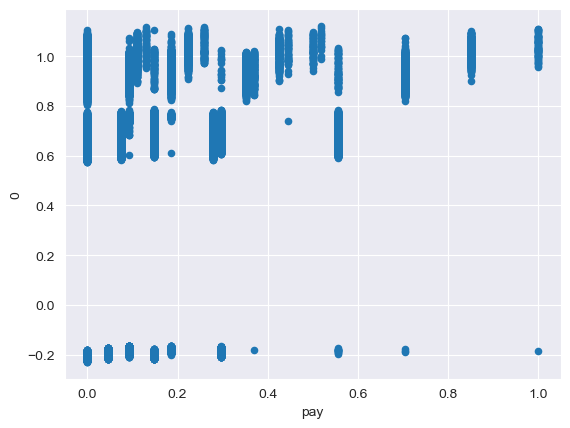

In [84]:
data_pca.plot(x='pay', y=0, kind='scatter')

In [85]:
data_pca = Tools.pca(2, data_nor)

In [86]:
data_pca

,0,1
0,-0.137948,-0.072621
1,0.841248,0.515828
2,0.757427,0.519541
3,-0.138404,-0.071220
4,-0.129347,0.545755
...,...,...
184011,-0.240669,-0.320061
184012,0.877117,-0.256918
184013,-0.245030,-0.357057
184014,-0.236274,0.001417


<AxesSubplot: xlabel='0', ylabel='1'>

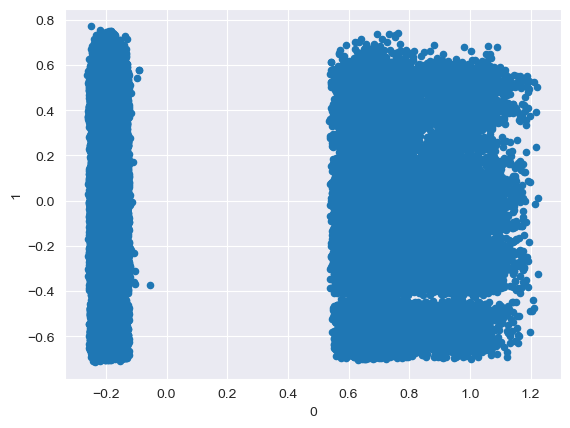

In [87]:
data_pca.plot(x=0, y=1, kind='scatter')

# Data Visualization

### *Columns Distribution*

In [89]:
# basic description
data_num.describe()

,APP_ID,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,...,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS
count,184016.000000,184016.000000,1.840160e+05,1.840160e+05,184016.000000,184016.000000,184016.000000,184016.000000,184016.000000,1.840160e+05,...,184016.0,184016.0,184016.0,184016.000000,184016.000000,184016.0,184016.0,184016.0,184016.0,184016.0
mean,193127.900280,89927.151405,4.996753e+07,4.249470e+07,3522.960552,74244.757554,6.338753,304.216481,431.522580,4.984453e+11,...,0.0,0.0,0.0,23933.781188,11120.438960,1.0,1.0,1.0,1.0,1.0
std,53937.173251,51910.772871,2.310008e+07,2.778991e+07,1965.956252,42663.836157,2.253402,362.306110,262.543112,2.897071e+11,...,0.0,0.0,0.0,17975.725412,13185.782079,0.0,0.0,0.0,0.0,0.0
min,100000.000000,0.000000,1.000005e+07,0.000000e+00,0.000000,0.000000,1.000000,0.000000,121.000000,1.200000e+01,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
25%,146363.750000,45002.750000,2.989969e+07,1.935293e+07,1645.000000,38081.750000,5.000000,0.000000,248.000000,2.474208e+11,...,0.0,0.0,0.0,8561.028413,790.302727,1.0,1.0,1.0,1.0,1.0
50%,192964.500000,89957.500000,5.004404e+07,4.297858e+07,3634.000000,74735.500000,6.000000,250.000000,432.000000,4.972180e+11,...,0.0,0.0,0.0,21744.822394,6843.079659,1.0,1.0,1.0,1.0,1.0
75%,239692.250000,134859.250000,6.992286e+07,6.644612e+07,5324.000000,111136.250000,9.000000,400.000000,683.000000,7.489220e+11,...,0.0,0.0,0.0,36720.922349,16443.183350,1.0,1.0,1.0,1.0,1.0
max,286957.000000,179813.000000,8.999999e+07,8.999956e+07,6717.000000,148142.000000,13.000000,2700.000000,936.000000,9.999940e+11,...,0.0,0.0,0.0,69998.933775,69998.256864,1.0,1.0,1.0,1.0,1.0


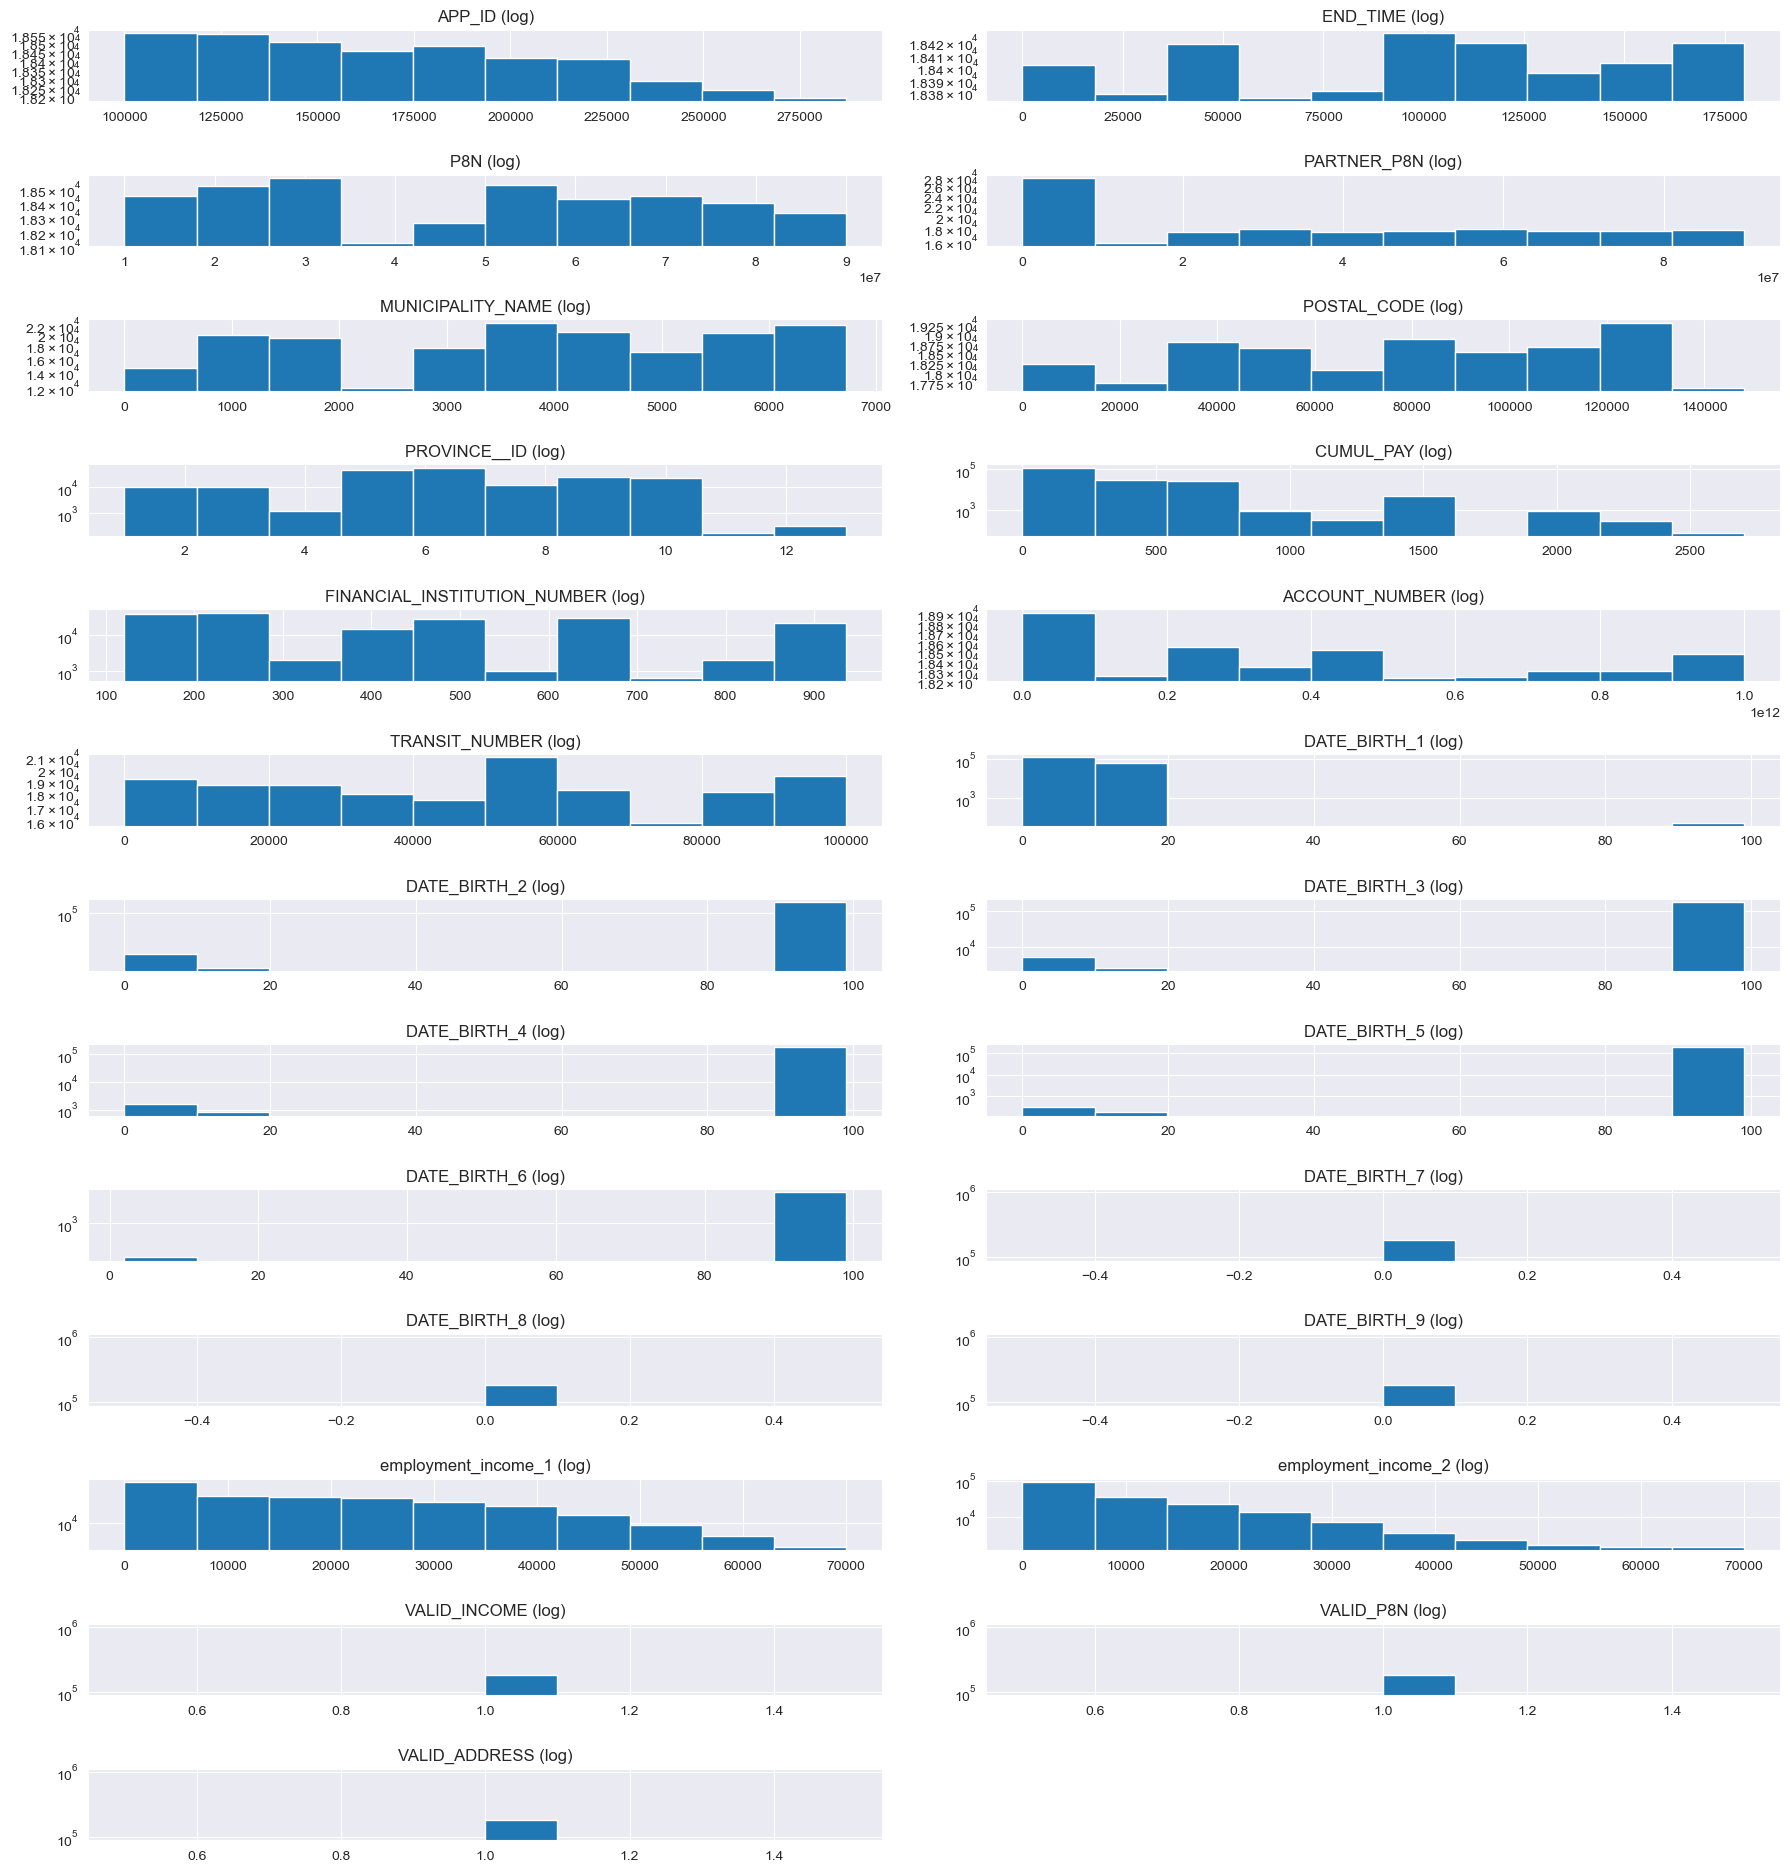

In [90]:
# other methods will check the time-based data; thus, we will skip this step
Tools.graph_frequency_numeric(data_num.iloc[:, :-2])

### *Correlation Detection*

In [91]:
data_nor.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,END_TIME,P8N,PARTNER_P8N,MUNICIPALITY_NAME,POSTAL_CODE,PROVINCE__ID,CUMUL_PAY,FINANCIAL_INSTITUTION_NUMBER,ACCOUNT_NUMBER,TRANSIT_NUMBER,DATE_BIRTH_1,DATE_BIRTH_2,DATE_BIRTH_3,DATE_BIRTH_4,DATE_BIRTH_5,DATE_BIRTH_6,DATE_BIRTH_7,DATE_BIRTH_8,DATE_BIRTH_9,employment_income_1,employment_income_2,VALID_INCOME,VALID_P8N,VALID_ADDRESS,VALID_BANK_ACC,VALID_KIDS
END_TIME,1.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.64,0.00,-0.01,-0.00,-0.01,0.02,0.01,0.00,0.00,0.00,nan,nan,nan,0.00,-0.00,nan,nan,nan,nan,nan
P8N,0.00,1.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,-0.00,0.00,nan,nan,nan,nan,nan
PARTNER_P8N,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.06,0.00,-0.00,-0.00,-0.01,0.01,0.00,0.00,0.00,-0.00,nan,nan,nan,-0.17,0.23,nan,nan,nan,nan,nan
MUNICIPALITY_NAME,-0.01,0.00,-0.00,1.00,-0.00,-0.04,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,nan,nan,nan,-0.00,-0.00,nan,nan,nan,nan,nan
POSTAL_CODE,-0.00,-0.00,-0.00,-0.00,1.00,0.94,0.00,0.00,-0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,-0.00,-0.00,nan,nan,nan,nan,nan
PROVINCE__ID,-0.00,-0.00,-0.00,-0.04,0.94,1.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,-0.00,-0.00,nan,nan,nan,nan,nan
CUMUL_PAY,-0.64,-0.00,0.06,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.02,-0.27,-0.19,-0.13,-0.08,-0.01,nan,nan,nan,-0.30,-0.17,nan,nan,nan,nan,nan
FINANCIAL_INSTITUTION_NUMBER,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,1.00,-0.01,0.06,-0.00,0.00,-0.00,-0.00,-0.00,0.00,nan,nan,nan,-0.00,-0.00,nan,nan,nan,nan,nan
ACCOUNT_NUMBER,-0.01,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.01,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,nan,nan,nan,0.00,-0.00,nan,nan,nan,nan,nan
TRANSIT_NUMBER,-0.00,-0.00,-0.00,0.00,-0.01,-0.01,0.00,0.06,0.00,1.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,nan,nan,nan,-0.00,0.00,nan,nan,nan,nan,nan
